# Optimisation
Optimisation plays an important role in the DoE process. It is important that the optimisation settings are appropriate for acquistion being optimised. If the acquistion function uses a QoI, the QoI behavior is also important.

The following acquistion characteristic impact the optimiser settings required.
- Stochasticity
- Smoothness (type of gradients available).

For each characteristic this notebook covers:
- How to assess your acqusition function for this characteristic.
- Optimisation implications

Additionally this notebook contains:
- Glossary of important optimiser setting.



In [ ]:
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from torch.utils.data import DataLoader, RandomSampler

from axtreme.acquisition.qoi_look_ahead import QoILookAhead
from axtreme.data import BatchInvariantSampler2d, MinimalDataset, SizableSequentialSampler
from axtreme.plotting.gp_fit import plot_1d_model
from axtreme.qoi import GPBruteForce
from axtreme.sampling import NormalIndependentSampler
from axtreme.utils.gradient import is_smooth_1d

torch.set_default_dtype(torch.float64)
device = "cpu"

## Example acquistion function

### Model:
NOTE: this is the exact model defined in `tests/conftest.py: model_singletaskgp_d1_t2`

c:\Users\SEBWIN\Documents\technical\code\TDR_rax2\TDR_rax\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0623,  0.6842]), std = tensor([0.8322, 0.3755])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


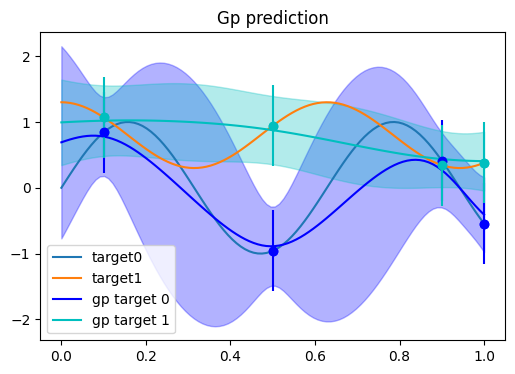

In [2]:
def target1(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(x * 10)


def target2(x: torch.Tensor) -> torch.Tensor:
    return 0.5 * torch.cos(x * 10) + 0.8


def y_func(x: torch.Tensor) -> torch.Tensor:
    return torch.concat([target1(x), target2(x)], dim=-1)


train_x = torch.tensor([[0.1], [0.5], [0.9], [1.0]])
train_y = y_func(train_x)

model = SingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=torch.ones_like(train_y) * 0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_mll(mll)

_, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.linspace(0, 1, 100).reshape(-1, 1)
_ = ax.plot(x, target1(x), label="target0")
_ = ax.plot(x, target2(x), label="target1")
_ = plot_1d_model(model, ax=ax)
_ = ax.legend()

### Create an example acquistion function
This is a smaller version of the typical Acquisiton/QoI combination we use. It freezes all sources of randomness to ensure it is deterministic

In [3]:
n_periods = 3
N_ENV_SAMPLES_PER_PERIOD = 1000

rng = np.random.default_rng(1337)

env_data = rng.normal(size=10_000) / 3 + 0.5
env_data = env_data[(env_data < 1) & (env_data > 0)]
env_data = env_data.reshape(-1, 1)  # Make it compatible
dataset = MinimalDataset(env_data)

gen = torch.Generator()
_ = gen.manual_seed(7)
sampler = RandomSampler(dataset, num_samples=n_periods * N_ENV_SAMPLES_PER_PERIOD, generator=gen, replacement=True)


sampler = SizableSequentialSampler(dataset, n_periods * N_ENV_SAMPLES_PER_PERIOD)

batch_sampler = BatchInvariantSampler2d(
    sampler=sampler,
    batch_shape=torch.Size([n_periods, 256]),
)
dataloader = DataLoader(dataset, batch_sampler=batch_sampler)

qoi = GPBruteForce(
    env_iterable=dataloader,
    erd_samples_per_period=1,
    posterior_sampler=NormalIndependentSampler(torch.Size([10]), seed=14),
    # When true, All uncertainty shown in estimates is due to uncertainty in the surrogate model.
    shared_surrogate_base_samples=True,
    no_grad=True,
    seed=12,
)

## Acqusition

In [6]:
acqf = QoILookAhead(model, qoi_estimator=qoi)

x_domain = torch.linspace(0, 1, 100).reshape(-1, 1)
acqf_scores = acqf(x_domain.unsqueeze(-1))
print(f"simple brute force max: score {acqf_scores.max().item()} at {x_domain[acqf_scores.argmax()].item()}")

simple brute force max: score -1.2920596106340014 at 0.16161616161616163


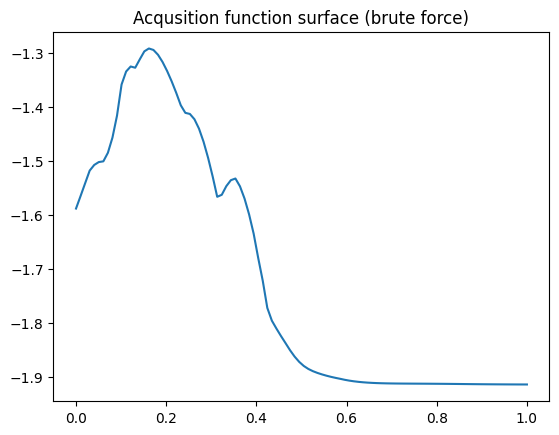

In [7]:
_ = plt.plot(x_domain.flatten(), acqf_scores)
_ = plt.title("Acqusition function surface (brute force)")

## Chracteristic: Stochastic Output
Acquisition which have stochastic output (randomness in the score they return) are not yet supported. `axtreme` assumes that the acquistion function is deterministic.

Note: Botorch support stochastic acquisition function. See `MCAcquisitionFunction` for further details.

### Assessing Stochasticity
A simple (although not conclusive) way to sanity check if your acquistion function is stochastic is to run it multiple times for the same input. If the results differ, the function is stochastic.

In [8]:
x_domain = torch.linspace(0, 1, 10).reshape(-1, 1)
acqf_scores1 = acqf(x_domain.unsqueeze(-1))
acqf_scores2 = acqf(x_domain.unsqueeze(-1))

torch.testing.assert_close(acqf_scores1, acqf_scores2)

## Characteristic: Smoothness
Smoothness (specifically, being once or twice differentiable) is an important property because it determines which optimisers can be used. Gradient based optimisation is typically more effecient, but requires smooth function.


### Assessing smoothness
A simple (although not conclusive) way to sanity check if your acquistion function is smooth is to run it for small changes in x and check the acquistion function remains smooth. We make use of a helper to do this.


In [9]:
x_domain = torch.linspace(0, 1, 100).reshape(-1, 1)
acqf_scores = acqf(x_domain.unsqueeze(-1))

Plot the result

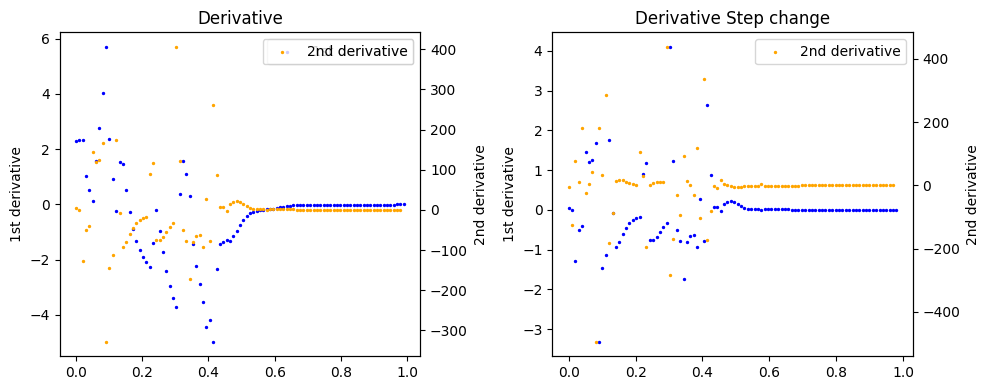

In [10]:
_ = is_smooth_1d(x_domain.flatten(), acqf_scores, plot=True, test=False)

Run the tests to check for 1st and 2nd degree smoothness.

NOTE: the threshold values may need to be adjusted for your specific problem

In [11]:
_ = is_smooth_1d(x_domain.flatten(), acqf_scores, d1_threshold=1)

AssertionError: First derivate is not smooth at indexes tensor([ 2,  5,  6,  7,  8,  9, 10, 11, 12, 23, 30, 31, 34, 41]).
 These indexes represent the the 0 based index of 'point_l' in the group of points 'point_l -- point_c -- point_r' in which the gradient has a step change.

### Optimisation Implications.
#### 0 times differentiable.
"Nelder-Mead" or other gradient free methods should be used. These can require a larger number of acquistion function runs, might be worth adjusting `maxiter`

```python
optimize_acqf(
    ...
    options = {
        "methed": "Nelder-Mead"
    }
)
```

#### 1 time differentiable
As above.

#### 2 times differentiable
Second order optimisation algorithems such as "L-BFGS-B" can be used

e.g
```python
optimize_acqf(
    ...
    options = {
        "methed": "L-BFGS-B"
    }
)
```


### Exploration of Nelder-Mead setting for this specific problem.
#### **1: Default params:**
Use default "Nelder-Mead" params. Note: all the params here differ from ax defaults.
```python
optimize_acqf(
    ...,
    num_restarts=6,
    raw_samples=10,
    options={
        "with_grad": False,  # True by default.
        "method": "Nelder-Mead",  # "L-BFGS-B" by default
    },
)
```
- runtime: 2:20 mins
- result: basically perfect

#### **2: brute force**
- 100 runs over linspace(0,1):
- runtime: 3 seconds
- function eval: 100

#### **3: Limit the maxiter or max functio neval**
- By default perfroms 200 maxiter and ~400 feval are used. Can reducing this give a suitably accurate result?


```python
optimize_acqf(
    ...,
    num_restarts=6,
    raw_samples=10,
    options={
        "with_grad": False,  # True by default.
        "method": "Nelder-Mead",  # "L-BFGS-B" by default
        "maxfev": 50, 
    },
    retry_on_optimization_warning= False
)
```
- runtime: 15 seconds, good results
- function eval: 10 + 6 * 50 = 310



#### **4: Best of random samples (skip opt)**
intuition: the brute force was fast and good enough. Can we do something equivalent trhough botorch.
```python
num_restarts=50,
raw_samples=50,
options={
    "with_grad": False,  # True by default.
    "method": "Nelder-Mead",  # "L-BFGS-B" by default
    "maxfev": 0, # this raises warning and it then retires unless set
    "batch_size": 50
},
retry_on_optimization_warning= False
```
- runtime: 5 seconds 50 pts
- runtime: 10 seconds with 100 pts
- function eval: 50 + 50 * 0 = 50


#### **4: Mix of points and optimisation**
```python
candidate, result = optimize_acqf(
   ...
    num_restarts=20,
    raw_samples=20,
    options={
        "with_grad": False,  # True by default.
        "method": "Nelder-Mead",  # "L-BFGS-B" by default
        #"fatol": .1
        "maxfev": 1, # this raises warning and it then retires unless set
        "batch_size":10,
        "init_batch_size": 20
    },
    retry_on_optimization_warning= False
)
```
- runtime: 3 seconds. Results start to get a bit rough
- function eval: 20 + 1 * 20 = 40
- NOTE: results starting to get a little rough (still in a good region)

In [39]:
candidate, result = optimize_acqf(
    acqf,
    bounds=torch.tensor([[0.0], [1.0]]),
    q=1,
    num_restarts=6,
    raw_samples=10,
    options={
        "with_grad": False,  # True by default.
        "method": "Nelder-Mead",  # "L-BFGS-B" by default
    },
)
candidate, result

(tensor([[0.1628]]), tensor(-1.2920))

In [91]:
"""These setting give us a suitable accuracy and runtime on this problem.

NOTE: When scaling to different problem consider adjusting the following params.
- maxfev: scipy default is 200 * n_dim in x.
- num_restarts: Note - ax does not change this depending on the problem.
- raw_samples: Note - ax does not change this depending on the problem.
"""
candidate, result = optimize_acqf(
    acqf,
    bounds=torch.tensor([[0.0], [1.0]]),
    q=1,
    num_restarts=30,
    raw_samples=30,
    options={
        "with_grad": False,  # True by default.
        "method": "Nelder-Mead",  # "L-BFGS-B" by default
        "maxfev": 4,  # this raises warning and it then retires unless set
        "batch_size": 10,
    },
    retry_on_optimization_warning=False,
)

candidate, result

(tensor([[0.1672]]), tensor(-1.2927))

## Optimiser Settings.
In this section we focus on the optimisation arguementz for the botorch function `optimize_acqf`. This is called by ax, and internally calls scipy (see [optimisation path](#optimisation-path) for details).

### `optimize_acqf`
The documentation for this function is found [here](https://botorch.org/api/optim.html#botorch.optim.optimize.optimize_acqf). The following provides additional imformation not listed in this documentation:

Basic behaviour: uses `gen_batch_initial_conditions` (or a custom method/points provided by user) to determine the initial points the optimisation should be tried from, then uses `scipy.optimize.minimize` to optimise those points.

Arguements:
- `acq_function`: See docs.
- `bounds`: See docs.
- `q`: See docs.
- `num_restarts`:
    - The number of initial points that the optimiser will start from (e.g how many different starting location will be used). This is used because the optimisation is typically non-convex/flat. Each restart is like an optimisation in local region.
    - default passed by ax: 20.
        - set in `ax\models\torch\botorch_modular\acquisition.py 418` using `ax\models\torch\botorch_modular\optimizer_argparse.py 33`
- `raw_samples`:
    - see [gen_batch_initial_conditions](#gen_batch_initial_conditions) section below.
    - default passed by ax: 1024.
        - set in `ax\models\torch\botorch_modular\acquisition.py 418` using `ax\models\torch\botorch_modular\optimizer_argparse.py 33`
- `options`: This is a dictionary of key value pairs
    - `nonnegative=False`: Set to true if the acquistion score can never be negative.
        - This is used in `gen_batch_initial_conditions` to help pick better inital points.
    - `init_batch_limit: int`: 
        - This is used in `gen_batch_initial_conditions`. See section for details. 
        - default passed by ax: 32.
            - set in `ax\models\torch\botorch_modular\acquisition.py 418` using `ax\models\torch\botorch_modular\optimizer_argparse.py 33`
    - `batch_limit`: int: controls how manch points are optimiseed at once in scipy (how many of the total `num_restart` points to do at once/in a single batch)
        - used in `botorch\optim\optimize.py 294`
        - default passed by ax: 5.
            - set in `ax\models\torch\botorch_modular\acquisition.py 418` using `ax\models\torch\botorch_modular\optimizer_argparse.py 33`
    - `with_grad=True`: If true, automatic differentiation (`torch.autograd.grad(loss,x)` of the scores w.r.t the input x's must be supported. This gradient is then provided directly to Scipy optimise.
        - NOTE: This does NOT control if gradient based optimisation is performed by Scipy (e.g Some Scipy method may internally estimate gradient if `with_grad=False`).
    - `method`: This is passed to `method` arguement of `scipy.optimize.minimize`. See [section](#scipyoptimizeminimize) for details.
        - `"L-BFGS-B"`: used by default if there are no constraints (`equality_constraints`, `inequality_constraints`, `nonlinear_inequality_constraints`)
        - `SLSQP`: used if constraints are present.
    - `maxiter=2000`: passed to `maxiter` options arguement in `scipy.optimize.minimize`. The max number of iterations of optimisation to perform.
        - a single iteration updates all points (in `batch_limit`) as the problem is posed to scipy as joint problem.
        - as per scipy "each iteration may use several function evaluations."
    - Additional args: specific to the method being used can be passed here.
- `inequality_constraints`: See docs.
- `equality_constraints`: See docs.
- `nonlinear_inequality_constraints`: See docs.
- `fixed_features`: See docs.
- `post_processing_func`: See docs.
- `batch_initial_conditions`: if provided, skips using `gen_batch_initial_conditions` internally, and uses these samples directly.
    - Should be of shape `num_restarts x q x d`.
- `return_best_only: = True`: If false, will return the optimisation results for the `num_restarts` rounds.
- `gen_candidates`: method to use internally instead of `gen_batch_initial_conditions`.
- `sequential=False`: if q > 1, optimise sequentially or jointly.
- `ic_generator`: See docs.
- `timeout_sec`: If exceeded, the `scipy.optimize.minimize` will be stopped, and returns the current state/progress of the optimiser, similar to when `maxiter` is reached.
- `return_full_tree`: No docs found.
- `retry_on_optimization_warning`: See docs.
- `**ic_gen_kwargs`: See docs.

#### `gen_batch_initial_conditions`
located here: `botorch\optim\initializers.py:423, in gen_batch_initial_conditions`
##### basic functionality
- first generate `raw_samples` many random x points.
- evaluates each one with the acquistion function.
- Uses a heuristic to pick `num_restart` of the `raw_sample` points (the function use the x location and the score from the acquistion function) 

##### Args:
- `raw_samples`: See basic functionality. The larger this number, the more times the acquistion function is run before Scipy. Majority of these will be discarded.
- `init_batch_limit`: How many of the `raw_samples` to pass to the acquistion function at once when scoring them. Decrease if acquistion function is having memory issues.

#### `scipy.optimize.minimize`

Args:
- `method=str`:
    - `"Nelder-Mead"`: Robust algorithem requiring no derivatives
    - `"L-BFGS-B"`: 
        - If gradient is not passed, will approximate gradient internally using finite difference (as per [here](https://stackoverflow.com/questions/18985048/error-using-l-bfgs-b-in-scipy)). 
        - Second order optimisation algo which approximates the hessian.
        - Acquistion function should be smooth (twice differentiable).
- 

### Optimisation path
The optimisation relationship from `ax` (bottom), through `botorch`, to `scipy` (top) is described in the following stack trace (with notes describing some key points):

```sh
minimize_with_timeout (botorch\optim\utils\timeout.py:80) 
#   scipy.optimize.minimize  is called here
gen_candidates_scipy (botorch\generation\gen.py:252)
#   "with_grad" used here to determine optimisation approach:
#       if True (line 192): 
#           - makes a wrapper around the acquistion function that give:  acq_wrapper(x) -> (funct_value, func_grad).
#           - jac=True in scipy.optimize.minimize
#       if False (line 224):
#           - wrapper returns:  acq_wrapper(x) -> funct_value
#           - jac=False in scipy.optimize.minimize
_optimize_batch_candidates (botorch\optim\optimize.py:333)
_optimize_acqf_batch (botorch\optim\optimize.py:349)
_optimize_acqf (botorch\optim\optimize.py:584)
optimize_acqf (botorch\optim\optimize.py:563)
optimize (ax\models\torch\botorch_modular\acquisition.py:439)
gen (ax\models\torch\botorch_modular\model.py:395)
_gen (ax\modelbridge\torch.py:682)
gen (ax\modelbridge\base.py:791)
TorchModelBridge.gen()
```

